# IMPORT

In [57]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import sklearn
import sys
from sklearn.linear_model import (LinearRegression, Ridge, Lasso,LogisticRegression, LassoCV)
from sklearn.model_selection import (KFold, cross_val_score, train_test_split, cross_validate)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import (Pipeline, make_pipeline)
from sklearn import preprocessing

# GET DATASET

In [58]:
df_train_ori = pd.read_csv('./Admission_Predict.csv')
df_train_ori = df_train_ori.drop(['Serial No.'],axis=1)

# PLOT USING SCATTER

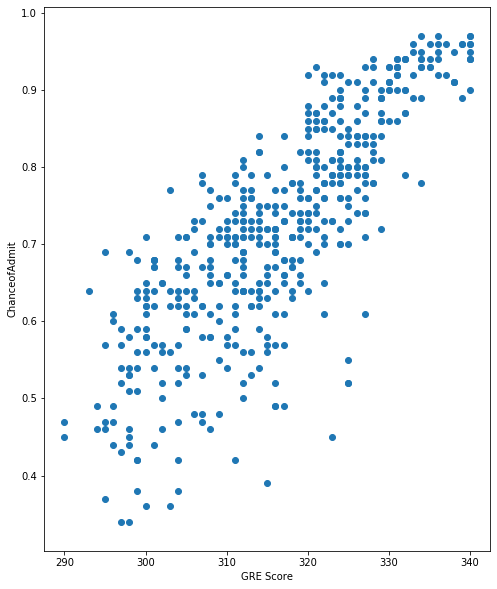

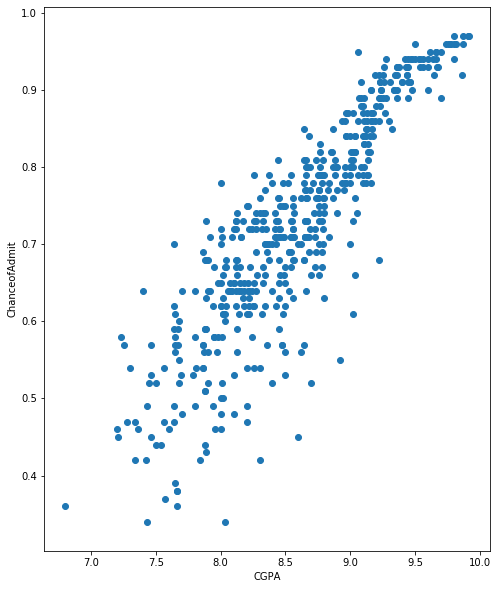

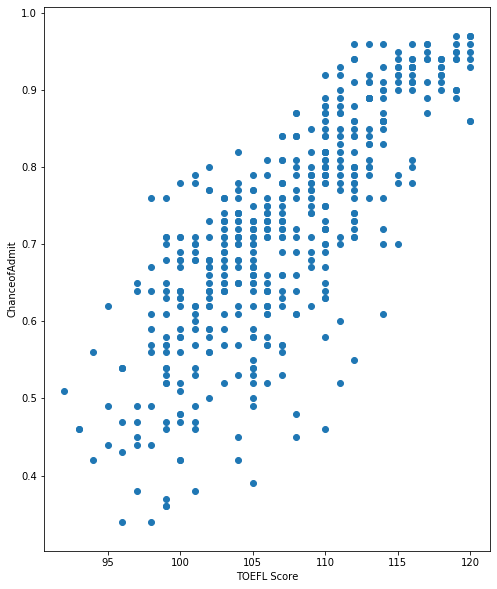

In [59]:
#Scatter plot to see if the relationships are linear. 
plt.scatter(x = df_train_ori['GRE Score'], y = df_train_ori['ChanceofAdmit'])
plt.ylabel('ChanceofAdmit')
plt.xlabel('GRE Score')
plt.show()

plt.scatter(x = df_train_ori['CGPA'], y = df_train_ori['ChanceofAdmit'])
plt.ylabel('ChanceofAdmit')
plt.xlabel('CGPA')
plt.show()

plt.scatter(x = df_train_ori['TOEFL Score'], y = df_train_ori['ChanceofAdmit'])
plt.ylabel('ChanceofAdmit')
plt.xlabel('TOEFL Score')
plt.show()

# LASSO WITH VARIOUS ALPHA

HERE   0.0005550868030059805
max score :  -0.003962320620243807 0.0005550868030059805 116
max pure :  0.8119971211750825 0.0024602398208697753 159


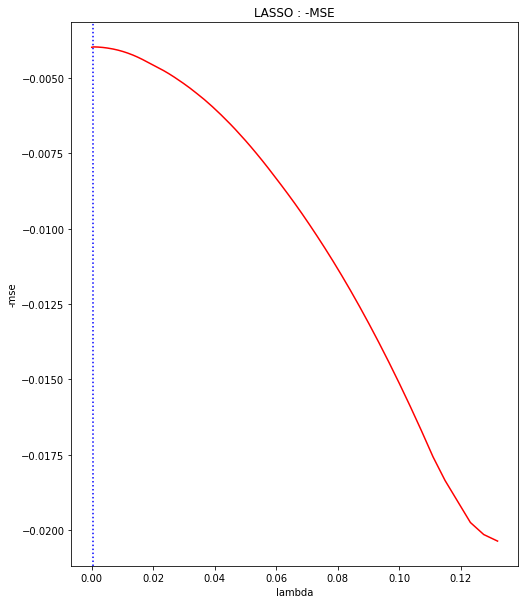

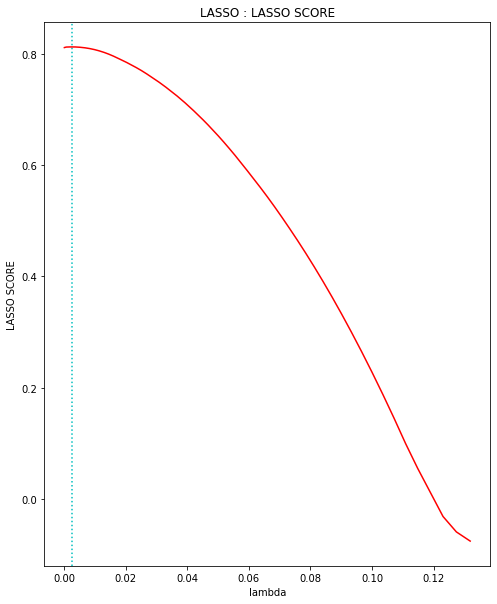

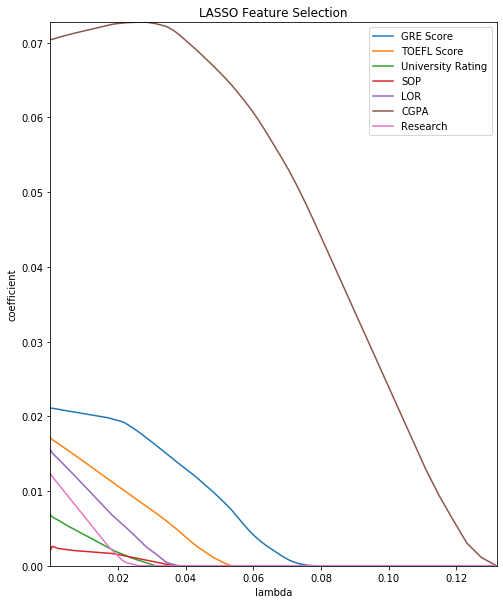

Maximum alpha where GRE Score  coefficient is nonzero :  [0.07580524]
Maximum alpha where TOEFL Score  coefficient is nonzero :  [0.05179475]
Maximum alpha where University Rating  coefficient is nonzero :  [0.03081214]
Maximum alpha where SOP  coefficient is nonzero :  [0.03538932]
Maximum alpha where LOR  coefficient is nonzero :  [0.0379269]
Maximum alpha where CGPA  coefficient is nonzero :  [0.1274275]
Maximum alpha where Research  coefficient is nonzero :  [0.02591396]


In [75]:
df_train_drop = df_train_ori.drop('ChanceofAdmit',1)
X = df_train_drop.values
y = df_train_ori.ChanceofAdmit.values
colnames = df_train_drop.columns
kf = KFold(n_splits=5)
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)


max_score=-1
max_score_alpha=0
alpha_valueArr = np.array([])
scoreArr = np.array([])
index=0
result_coef = np.ndarray(shape=(df_train_drop.shape[1],700), dtype=float)
alphas = np.logspace(-5, 1, 400)
featureArr = np.ones((df_train_drop.shape[1],1))
purescoreArr=[]
max_pure_alpha=0
max_pure_score=-1
for alpha_value in alphas:
    clf = Lasso(alpha=alpha_value)#,normalize=True)
    #cv_result=cross_validate(clf,X,y,cv=kf, return_estimator=True)
    cv_result=cross_validate(clf,X,y,scoring='neg_mean_squared_error',cv=kf, return_estimator=True)
    scores = cv_result['test_score']
    pure=cross_val_score(clf,X,y,cv=kf)
    purescoreArr.append(np.mean(pure))
    
    if max_score<=np.mean(scores):
        max_score=np.mean(scores)
        max_score_alpha=alpha_value 
    if max_pure_score<=np.mean(pure):
        max_pure_score=np.mean(pure)
        max_pure_alpha=alpha_value 
    alpha_valueArr = np.concatenate((alpha_valueArr, np.array([alpha_value])), axis=0)
    scoreArr = np.concatenate((scoreArr, np.array([np.mean(scores)])), axis=0)
    cv_result_es=cv_result['estimator']
    itercoef=((np.array(cv_result_es[0].coef_))+(np.array(cv_result_es[1].coef_))+(np.array(cv_result_es[2].coef_))+(np.array(cv_result_es[3].coef_))+(np.array(cv_result_es[4].coef_)))/5
    for i in range(7):
        result_coef[i][index]=itercoef[i]
        if itercoef[i]!=0:
            featureArr[i]=alpha_value
    if index==116:
        print('HERE  ',alpha_value)
    index+=1
    
    if np.max(itercoef)==0:
        break
        
print('max score : ',max_score, max_score_alpha, np.where(alphas==max_score_alpha)[0][0])
print('max pure : ',max_pure_score, max_pure_alpha, np.where(alphas==max_pure_alpha)[0][0])

clf = LinearRegression()
scores=cross_val_score(clf,X,y,cv=kf)

plt.title('LASSO : -MSE')
plt.xlabel('lambda')
plt.ylabel('-mse')
plt.axvline(max_score_alpha, color='b', linestyle=':')
plt.plot(alpha_valueArr[0:(alpha_valueArr.shape[0])],scoreArr[0:(alpha_valueArr.shape[0])],'r')
plt.show()
#################
plt.title('LASSO : LASSO SCORE')
plt.xlabel('lambda')
plt.ylabel('LASSO SCORE')
plt.axvline(max_pure_alpha, color='c', linestyle=':')
plt.plot(alpha_valueArr[0:(alpha_valueArr.shape[0])],purescoreArr[0:(alpha_valueArr.shape[0])],'r')
plt.show()
#################

plt.title('LASSO Feature Selection')
plt.xlabel('lambda')
plt.ylabel('coefficient')
colors = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','b', 'g', 'r', 'c', 'm', 'y', 'k']
for x in range(df_train_drop.shape[1]):
    plt.plot(alpha_valueArr[0:(alpha_valueArr.shape[0])],result_coef[x][0:(alpha_valueArr.shape[0])],colors[x], label=colnames[x])

plt.legend()
plt.margins(0.00001)

#plt.ylim(0,np.mean(lasso.coef_))
plt.show()

for x in range(df_train_drop.shape[1]):
    print('Maximum alpha where',colnames[x],' coefficient is nonzero : ',featureArr[x])


# LASSOCV FOR FEATURE SELECTION
### It doesn't eliminate any variables
### This dataset isn't proper to do feature selection through LASSO

Best alpha using built-in LassoCV: 0.000578
Best score using built-in LassoCV: 0.821873
Lasso picked 7 variables and eliminated the other 0 variables


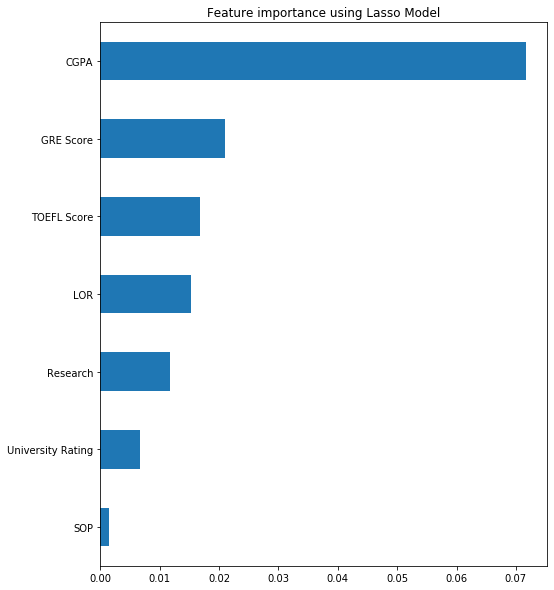

In [76]:
reg = LassoCV(cv=5)#, normalize=True)
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = colnames)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
mpl.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

# RIDGE

max:  0.8108013487015853 1e-05
(7, 10000)
0.8108015220863883
GRE Score
400 (400,)
0


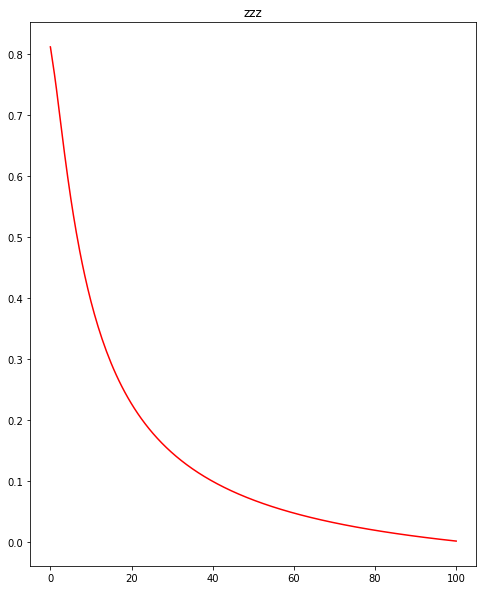

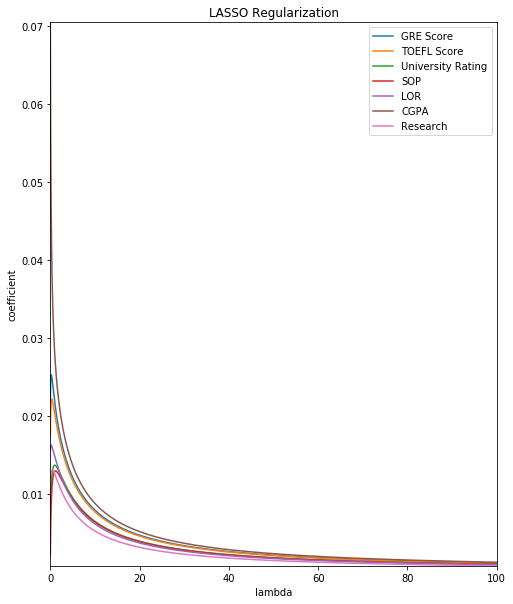

Maximum alpha where GRE Score  coefficient is nonzero :  [100.]
Maximum alpha where TOEFL Score  coefficient is nonzero :  [100.]
Maximum alpha where University Rating  coefficient is nonzero :  [100.]
Maximum alpha where SOP  coefficient is nonzero :  [100.]
Maximum alpha where LOR  coefficient is nonzero :  [100.]
Maximum alpha where CGPA  coefficient is nonzero :  [100.]
Maximum alpha where Research  coefficient is nonzero :  [100.]


In [54]:

colnames = df_train_drop.columns
kf = KFold(n_splits=5)
alpha_value=0.00001
max_score=-1
max_score_alpha=0
alpha_valueArr = np.array([])
scoreArr = np.array([])
index=0
result_coef = np.ndarray(shape=(df_train_drop.shape[1],10000), dtype=float)
alphas = np.logspace(-5, 2, 400)
featureArr = np.ones((df_train_drop.shape[1],1))
for alpha_value in alphas:
    clf = Ridge(alpha=alpha_value,normalize=True)
    cv_result=cross_validate(clf,X,y,cv=kf, return_estimator=True)
    #cv_result=cross_validate(clf,X,y,scoring='neg_mean_squared_error',cv=kf, return_estimator=True)
    scores = cv_result['test_score']
    if max_score<np.mean(scores):
        max_score=np.mean(scores)
        max_score_alpha=alpha_value 
    alpha_valueArr = np.concatenate((alpha_valueArr, np.array([alpha_value])), axis=0)
    scoreArr = np.concatenate((scoreArr, np.array([np.mean(scores)])), axis=0)
    
    round(alpha_value,5)    
    cv_result_es=cv_result['estimator']
    itercoef=((np.array(cv_result_es[0].coef_))+(np.array(cv_result_es[1].coef_))+(np.array(cv_result_es[2].coef_))+(np.array(cv_result_es[3].coef_))+(np.array(cv_result_es[4].coef_)))/5
    
    for i in range(7):
        result_coef[i][index]=itercoef[i]
        if itercoef[i]!=0:
            featureArr[i]=alpha_value
    alpha_value += 0.00001
    index+=1
    
    if np.max(itercoef)==0:
        break
        
print('max: ',max_score, max_score_alpha)
print(np.array(result_coef).shape)

clf = LinearRegression()
scores=cross_val_score(clf,X,y,cv=kf)
print(np.mean(scores))
print(colnames[0])
#print(alpha_valueArr.size, alpha_valueArr)
import sys
#np.set_printoptions(threshold=sys.maxsize)
#print(scoreArr.size, scoreArr)

#for x in range(df_train_drop.shape[1]):
 #   plt.plot(lambdaArr[firstNonZeroIndex:lastIndex],lassoCoefArr[x][firstNonZeroIndex:lastIndex],colors[x], label=colnames[x])
plt.title('zzz')
print(alpha_valueArr.shape[0],scoreArr.shape)
plt.plot(alpha_valueArr[0:(alpha_valueArr.shape[0])],scoreArr[0:(alpha_valueArr.shape[0])],'r')
print(np.argmax(scoreArr))
plt.show()

#################

plt.title('LASSO Regularization')
plt.xlabel('lambda')
plt.ylabel('coefficient')
colors = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','b', 'g', 'r', 'c', 'm', 'y', 'k']
for x in range(df_train_drop.shape[1]):
    plt.plot(alpha_valueArr[0:(alpha_valueArr.shape[0])],result_coef[x][0:(alpha_valueArr.shape[0])],colors[x], label=colnames[x])

plt.legend()
plt.margins(0.00001)
#plt.ylim(0,np.mean(lasso.coef_))
plt.show()

for x in range(df_train_drop.shape[1]):
    print('Maximum alpha where',colnames[x],' coefficient is nonzero : ',featureArr[x])